<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>HSC Cosmos I-Band Analysis Notebook</b> <br>
Contact author: Brianna Smart<br>
Last verified to run: -  09/06/2022<br>
LSST Science Piplines version: - 32 Large Container<br>
Container Size: Large <br>

The purpose of this notebook is to create analysis plots of the HSC Cosmos reprocessed i-band. The i-band had to be reprocessed twice in two seperate pipetask runs, as the sky images were not present upon the initial run and caused the initial pipetask attempt to fail. A second run appended with "coadds" was then run, skipping the sky images and going straight to the warps.

### 1.1 Setup

In [2]:
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
from IPython.display import IFrame
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
import gc

afwDisplay.setDefaultBackend('matplotlib') 

In [3]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

In [4]:
def firefly_plots (datasetRefs):
    IFrame(display1.getClient().get_firefly_url(), 1100, 700)
    
    for i, ref in enumerate(datasetRefs):
        f, axarr = plt.subplots(1,2)
        calexp = butler.getDirect(ref)
        print(i, ' calexp.detector.getId(): ', calexp.detector.getId())
        fig = plt.figure()
        calexpIm = afwDisplay.Display(frame=i*2)
        calexpIm.setMaskTransparency(90)
        calexpIm.scale('asinh', -1, 30)
        calexpIm.mtv(calexp)
        display = afwDisplay.Display(frame=i*2+1)
        display.scale('asinh', 'zscale')
        display.mtv(calexp.variance)
        if i > 2:
            print('...')
            break


In [5]:
def m_and_v_plots (datasetRefs, matplot=None, display_num=None):
    
    
    if not display_num:
        display_num=3
    else:
        display_num=display_num
    
    if matplot != None:
        afwDisplay.setDefaultBackend('matplotlib') 
        
        for i, ref in enumerate(datasetRefs):

            calexp = butler.getDirect(ref)
            print('Visit: ', calexp.visitInfo.getId(), ', Detector: ',calexp.detector.getId())
            fig, ax = plt.subplots(1, 3, figsize=(14, 7))
            plt.sca(ax[0])  # set the first axis as current
            plt.xlabel('Image with Mask Overlay')
            display1 = afwDisplay.Display(frame=fig)
            display1.scale('asinh', -1, 30)
            display1.mtv(calexp)
            plt.sca(ax[1])  # set the second axis as current
            display2 = afwDisplay.Display(frame=fig)
            display2.mtv(calexp.mask)
            plt.tight_layout()
            plt.sca(ax[2]) 
            display3 = afwDisplay.Display(frame=fig)
            display3.scale('asinh', 'zscale')
            display3.mtv(calexp.variance)
            plt.tight_layout()
            plt.show()
            remove_figure(fig)
            
            if i == display_num:
                print('...')
                break

    else:
        afwDisplay.setDefaultBackend('firefly')
        for i, ref in enumerate(datasetRefs):

            calexp = butler.getDirect(ref)
            print('Visit: ', calexp.visitInfo.getId(), ', Detector: ',calexp.detector.getId())
            display = afwDisplay.Display(frame=3*i)
            display.scale('asinh', -1, 30)
            display.mtv(calexp)
            display = afwDisplay.Display(frame=3*i+1)
            display.setMaskTransparency(90)
            display.mtv(calexp.mask)
            display = afwDisplay.Display(frame=3*i+2)
            display.scale('asinh', 'zscale')
            display.mtv(calexp.variance)

            if i == display_num:
                print('...')
                break

In [6]:
def source_scatter_plots (datasetRefs):
    afwDisplay.setDefaultBackend('matplotlib') 
    
    for i, ref in enumerate(datasetRefs):
        calexp = butler.getDirect(ref)
        display1 = afwDisplay.Display(frame=1)
        display1.setMaskTransparency(80)
        display1.scale('asinh', -1, 30)
        display1.mtv(calexp)
        #src = butler.get('src', ref)
        src = butler.get('src', ref.dataId)
        with display1.Buffering():
            for record in src:
                display1.dot('o', record.getX(), record.getY(), size=20, ctype='orange')
        
        if i > 3:
            print('...')
            break

In [37]:
def psf_plots (datasetRefs):
    for i, ref in enumerate(datasetRefs):
        
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
        plt.sca(ax[0])  # set the first axis as current
        plt.xlabel('Image with Mask Overlay')
        display1 = butler.getDirect(ref)
        display1 = afwDisplay.Display(frame=fig)
        display1.setMaskTransparency(80)
        display1.scale('asinh', -1, 30)
        display1.mtv(calexp)
        src = butler.get('src', dataId)
        print(src['base_PsfFlux_instFlux'])
        
        with display1.Buffering():
            for s in src[src['calib_psf_used']]:
                display1.dot("x", s.getX(), s.getY(), size=10, ctype='red')
        rejectedPsfSources = src[src['calib_psf_candidate'] &
                             (src['calib_psf_used'] == False)]
        with display1.Buffering():
            for s in rejectedPsfSources:
                display1.dot("+", s.getX(), s.getY(), size=10, ctype='green')
                
        plt.sca(ax[1])  # set the first axis as current
        psf = calexp.getPsf()
        position = psf.getAveragePosition()
        display1 = afwDisplay.Display(frame=fig)
        display1.mtv(psf.computeImage(position))
        
        if i > 3:
            print('...')
            break

The below code snippits are currently from Ian's image substraction step of the refactored image differencing notebook.

In [8]:
def plot_variance(exposure, label='', smooth=0):
    print(f"Median value of the variance pixels: {np.nanmedian(exposure.variance.array)}")
    try:
        fig = plt.figure(figsize=(10,8))      # create a matplotlib.pyplot figure
        afw_display = afwDisplay.Display(1)   # create an alias for the lsst.afw.display.Display() method
        afw_display.scale('linear', 'zscale')  # set the algorithm and scale for the pixel shading
        if smooth > 0:
            array = scipy.ndimage.median_filter(exposure.variance.array, smooth)
            exposure = exposure.clone()
            exposure.variance.array[...] = array
        afw_display.mtv(exposure.variance)   # display the image data you retrieved with the butler
        plt.gca().axis('off')                 # turn off the x and y axes labels
        plt.title(f"{label} variance")
        plt.show()
    except AssertionError:
        print(f"{label} variance is entirely {np.nanmedian(exposure.image.array)}")

        
def plot_image(exposure, label='Old', smooth=0):
    print(f"Median value of the image pixels: {np.nanmedian(exposure.image.array)}")
    try:
        fig = plt.figure(figsize=(10,8))      # create a matplotlib.pyplot figure
        afw_display = afwDisplay.Display(1)   # create an alias for the lsst.afw.display.Display() method
        afw_display.scale('linear', 'zscale')  # set the algorithm and scale for the pixel shading
        if smooth > 0:
            array = scipy.ndimage.median_filter(exposure.image.array, smooth)
            exposure = exposure.clone()
            exposure.image.array[...] = array
        afw_display.mtv(exposure.image)   # display the image data you retrieved with the butler
        plt.gca().axis('off')                 # turn off the x and y axes labels
        plt.title(f"{label} image")
        plt.show()
    except AssertionError:
        print(f"{label} image is entirely {np.nanmedian(exposure.image.array)}")

### 1.2 Load in Data

In [9]:
instrument= 'HSC'
skymap= 'hsc_rings_v1' 
repo = "/repo/main_20220411"
coadd_collection = "u/smart/DM-35709/hsc-9813-templates-i-coadds"
reprocess_collection = "u/smart/DM-35709/hsc-9813-templates-i"

butler = Butler(repo, collections=[coadd_collection,reprocess_collection])
registry = butler.registry

### 1.3 Exploring data

This section is meant to help a user explore and understand more about how the data is structured and how to find specific values.

In [10]:
for d in sorted(registry.queryDatasetTypes()): print(d.name)

AB1_config
AB1_log
AB1_metadata
AD1_design_config
AD1_design_log
AD1_design_metadata
AD2_design_config
AD2_design_log
AD2_design_metadata
AD3_design_config
AD3_design_log
AD3_design_metadata
AF1_design_config
AF1_design_log
AF1_design_metadata
AF2_design_config
AF2_design_log
AF2_design_metadata
AF3_design_config
AF3_design_log
AF3_design_metadata
AM1_config
AM1_log
AM1_metadata
AM2_config
AM2_log
AM2_metadata
AM3_config
AM3_log
AM3_metadata
GblsstSkyWcsCatalog
PA1_config
PA1_log
PA1_metadata
PF1_design_config
PF1_design_log
PF1_design_metadata
TE1_config
TE1_log
TE1_metadata
TE2_config
TE2_log
TE2_metadata
TE3_config
TE3_log
TE3_metadata
TE4_config
TE4_log
TE4_metadata
analyzeObjectTableCore_config
analyzeObjectTableCore_log
analyzeObjectTableCore_metadata
assembleCoadd_config
assembleCoadd_log
assembleCoadd_metadata
bfKernel
bias
brightObjectMask
calexp
calexpBackground
calexp_camera
calibrate_config
calibrate_log
calibrate_metadata
camera
catalogMatchTract_config
catalogMatchTract_l

In [11]:
dt = registry.getDatasetType('calexp')
print("Name:", dt.name)
print("Dimensions:", dt.dimensions)
print("Storage Class:", dt.storageClass)

Name: calexp
Dimensions: {band, instrument, detector, physical_filter, visit_system, visit}
Storage Class: ExposureF


If I want to look at a specific image, but don't know it's tract ID or Patch number, I can use the code below.

In [12]:
i=0
for data_id in butler.registry.queryDataIds(["tract", "visit", "detector", "patch"],
    datasets="visitSummary",
    collections=[coadd_collection,reprocess_collection],
    instrument=instrument
):
    
    i=i+1
    print(data_id['tract'], data_id['patch'])
    
    if i > 3:
        print('...')
        break

9570 72
9571 79
9571 80
9813 3
...



### 2.1 Calexp Selection

The section below is a selection of calexp, their masks and variance planes.

In [13]:
datasetType = 'calexp'
datasetRefs = set(registry.queryDatasets(datasetType, dataId=None))

Using plot to display calexp. However, Firefly is better as it allows for overlaying of masks and sources. The below plot is the image with the mask overlaid, the mask itself, and the variance.

Visit:  30484 , Detector:  0


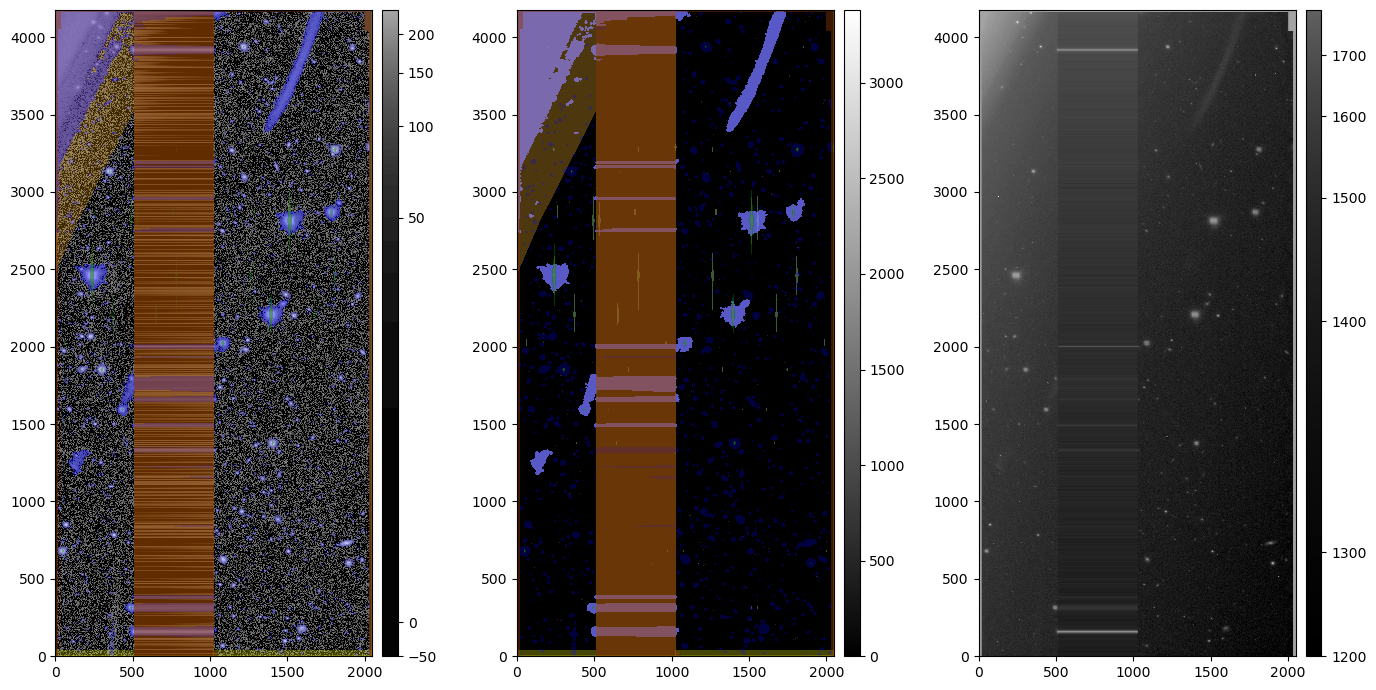

Visit:  30496 , Detector:  57


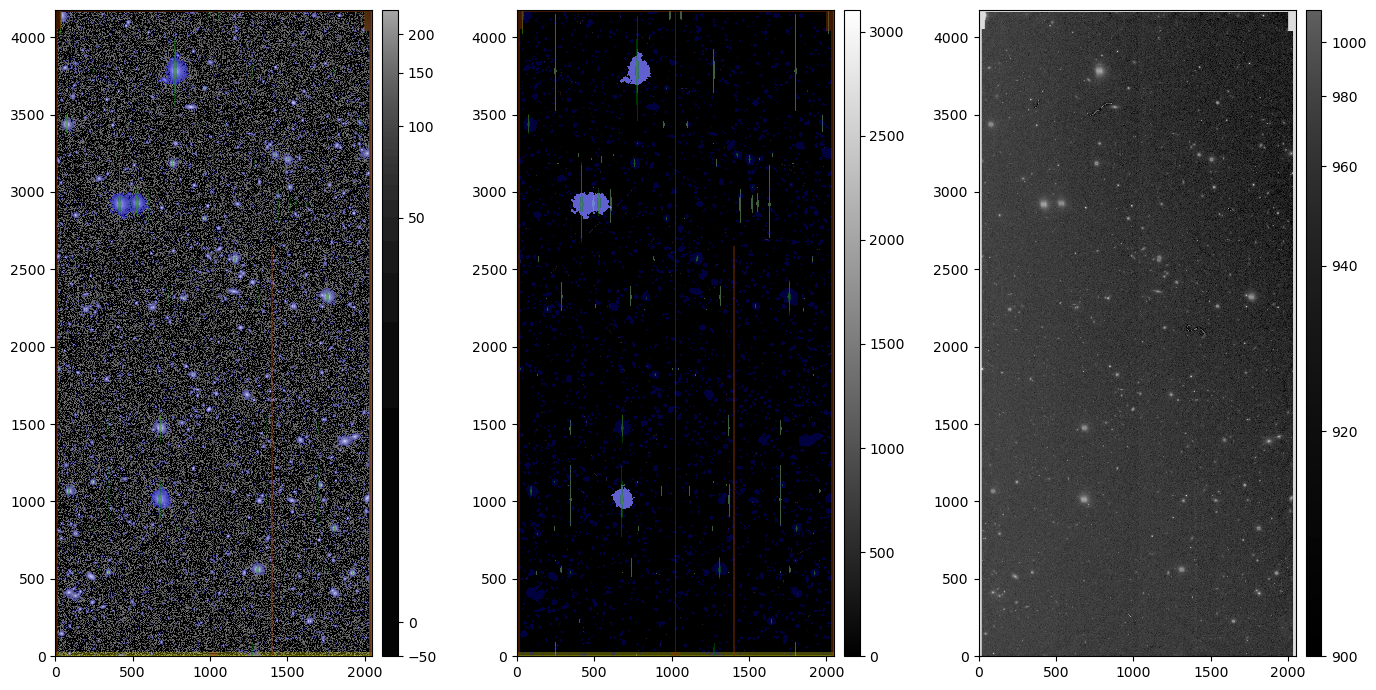

Visit:  30504 , Detector:  100


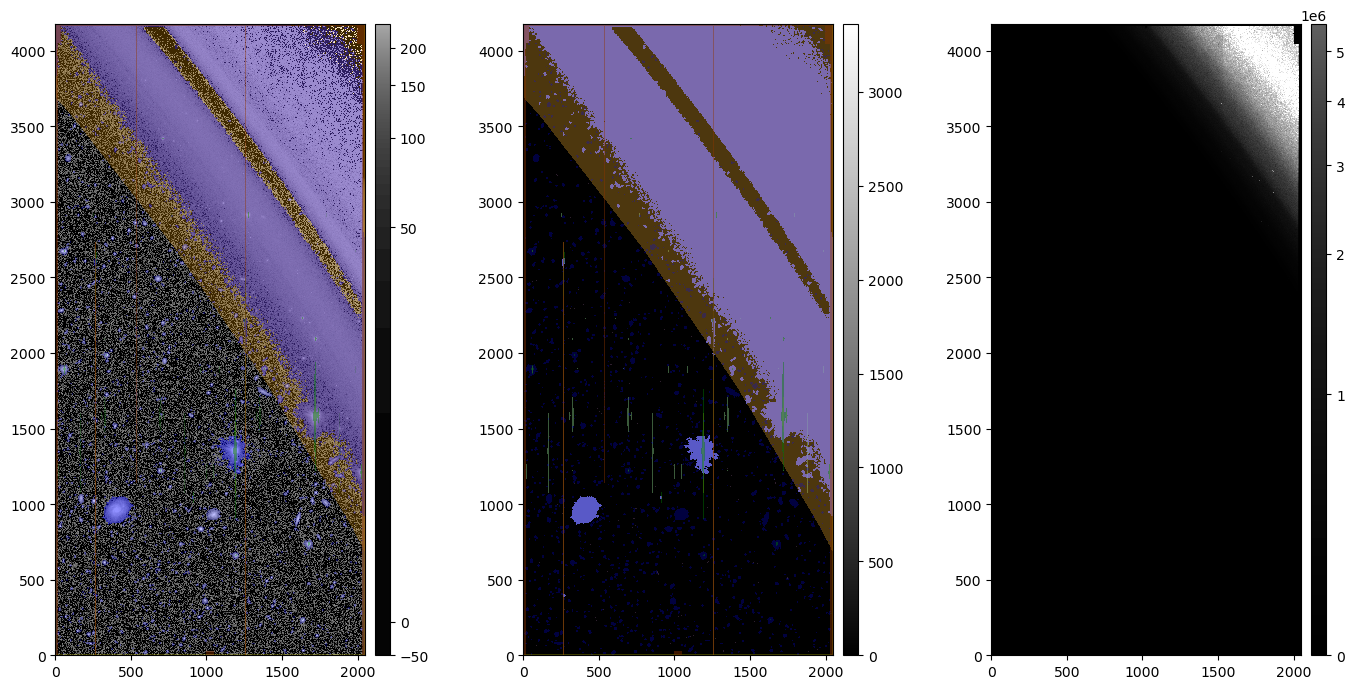

Visit:  30494 , Detector:  22


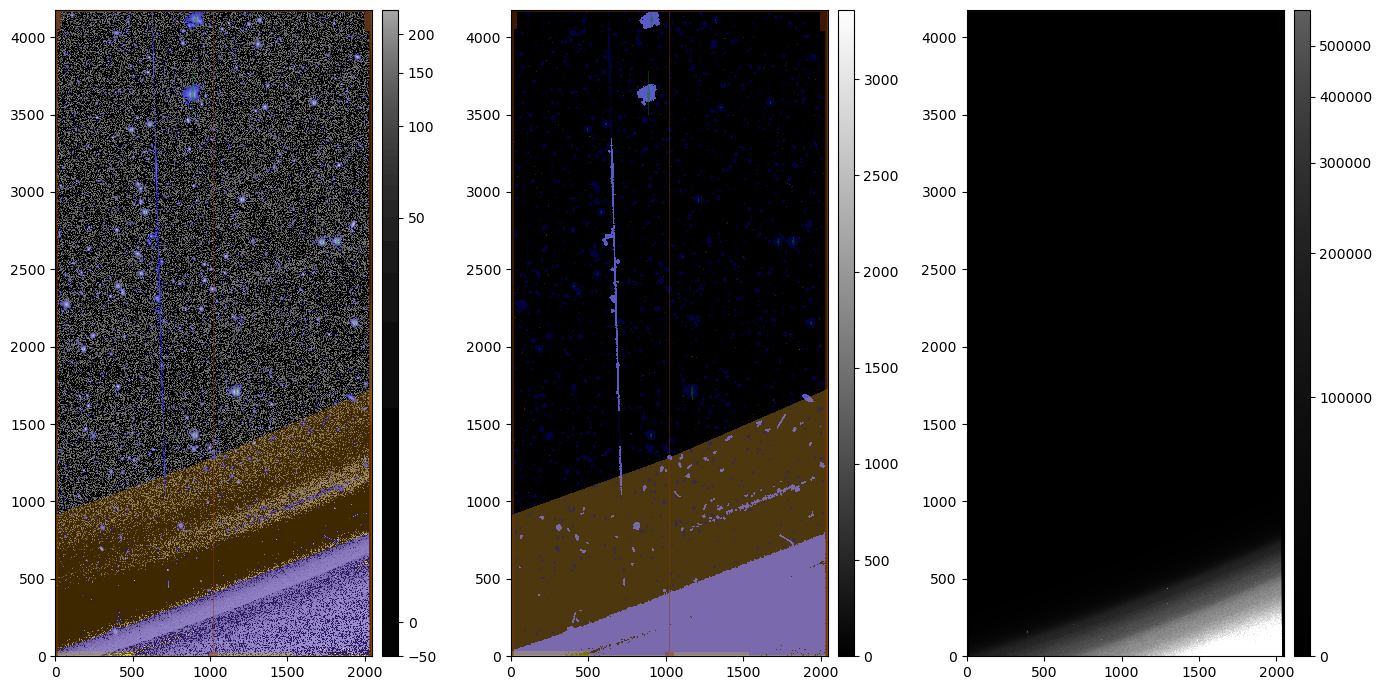

...


In [14]:
m_and_v_plots(datasetRefs, matplot='matplot')

### 2.2 Multiple image Firefly Display

from IPython.display import IFrame
IFrame(afw_display1.getClient().get_firefly_url(), 1100, 700)Here we display the same images as above, but instead of writing to the notebook they are displayed in Firefly. Currently, there is an issue where, if more than one image with a mask is displayed at once, the most recently displayed image's mask overwrites  all of the masks for the previously displayed images.

If the below lines are not included, but have been in a previous notebook that is active in your kernel, your output will be displayed into THAT notebook.


In [15]:
afwDisplay.setDefaultBackend('firefly')
display = afwDisplay.Display(frame=1)
IFrame(display.getClient().get_firefly_url(), 1100, 700)

In [16]:
m_and_v_plots(datasetRefs)

Visit:  30484 , Detector:  0
Visit:  30496 , Detector:  57
Visit:  30504 , Detector:  100
Visit:  30494 , Detector:  22
...


The above way of displaying seems to have an issue where the masks render correctly inittially, but at the end the wrong masks are applied to the images. This issue has been raised with the Firefly DM team.


In [17]:
display.clearViewer()

In [18]:
afwDisplay.setDefaultBackend('firefly')
display2 = afwDisplay.Display(frame=0)
IFrame(display2.getClient().get_firefly_url(), 1100, 700)

In [19]:
dataId ={'detector':0,'visit': 19682, 'skymap': 'hsc_rings_v1', 'instrument': 'HSC', 'band': 'i'}

datasetType= 'calexp'
datasetRefs = set(registry.queryDatasets(datasetType, dataId=dataId))

m_and_v_plots(datasetRefs,display_num=0)

Visit:  19682 , Detector:  0


Example of a single calexp once the display is cleared.

In [20]:
display.clearViewer()

### Image Source Scatter Plots

In [21]:
afwDisplay.setDefaultBackend('firefly')
display = afwDisplay.Display(frame=0)
IFrame(display.getClient().get_firefly_url(), 1100, 700)
    

In [22]:
for i, ref in enumerate(datasetRefs):
    calexp = butler.getDirect(ref)
    display = afwDisplay.Display(frame=0)
    display.setMaskTransparency(80)
    display.scale('asinh', -1, 30)
    display.mtv(calexp)
    
    src = butler.get('src', ref.dataId)
    with display.Buffering():
        for record in src:
            display.dot('o', record.getX(), record.getY(), size=20, ctype='orange')

This is another example plotting with matplot

Visit:  30494 , Detector:  103


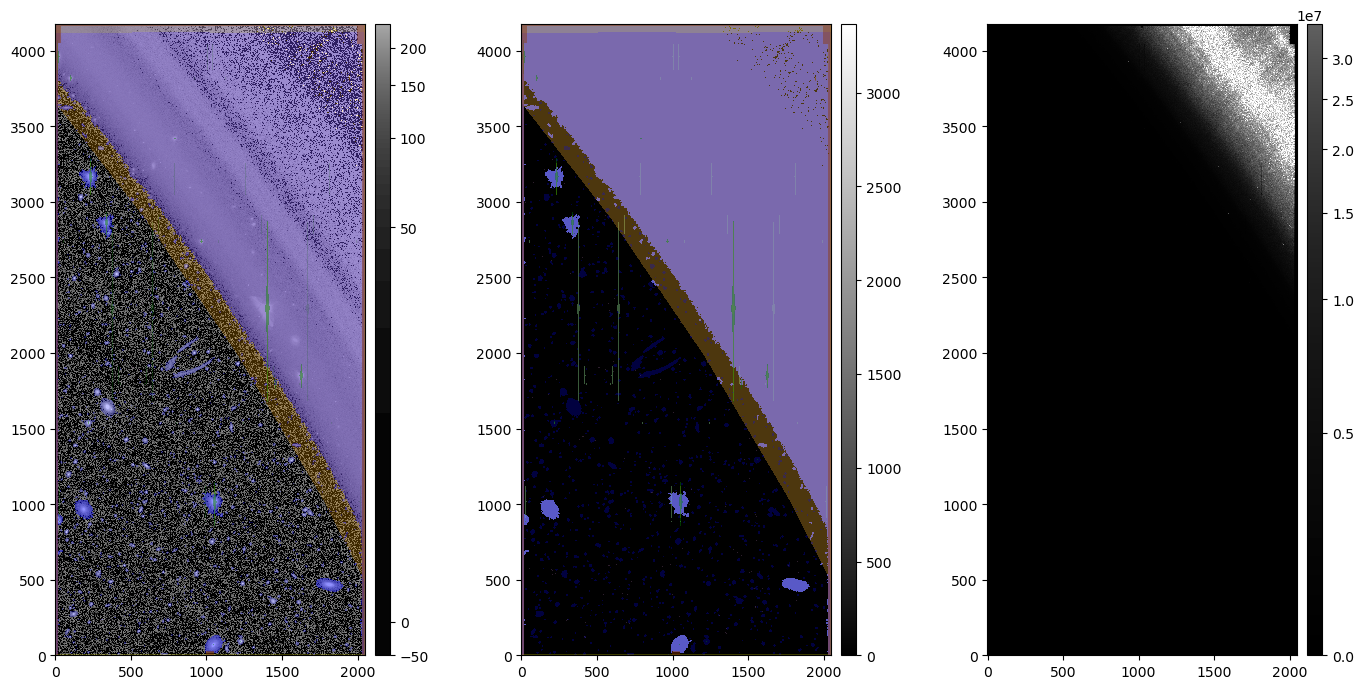

In [23]:
dataId ={'detector':103,'visit': 30494, 'skymap': 'hsc_rings_v1', 'instrument': 'HSC', 'band': 'i','tract': 9813, 'patch': 31}
datasetRefs = set(registry.queryDatasets('calexp', dataId=dataId))

m_and_v_plots(datasetRefs, matplot=True)

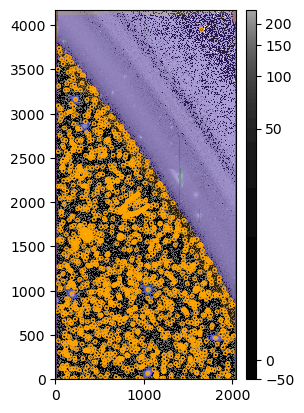

In [24]:
datasetRefs = set(registry.queryDatasets('calexp', dataId=dataId))
source_scatter_plots(datasetRefs)

### PSF Sources of Selected Images

The plot below marks in green all of the PSF sources which were used and in red the rejected PSF.

[  1853.59544622   2528.15302691   3491.31117906 ... 121617.76935433
   6282.68577966   3464.2522861 ]
[  1853.59544622   2528.15302691   3491.31117906 ... 121617.76935433
   6282.68577966   3464.2522861 ]


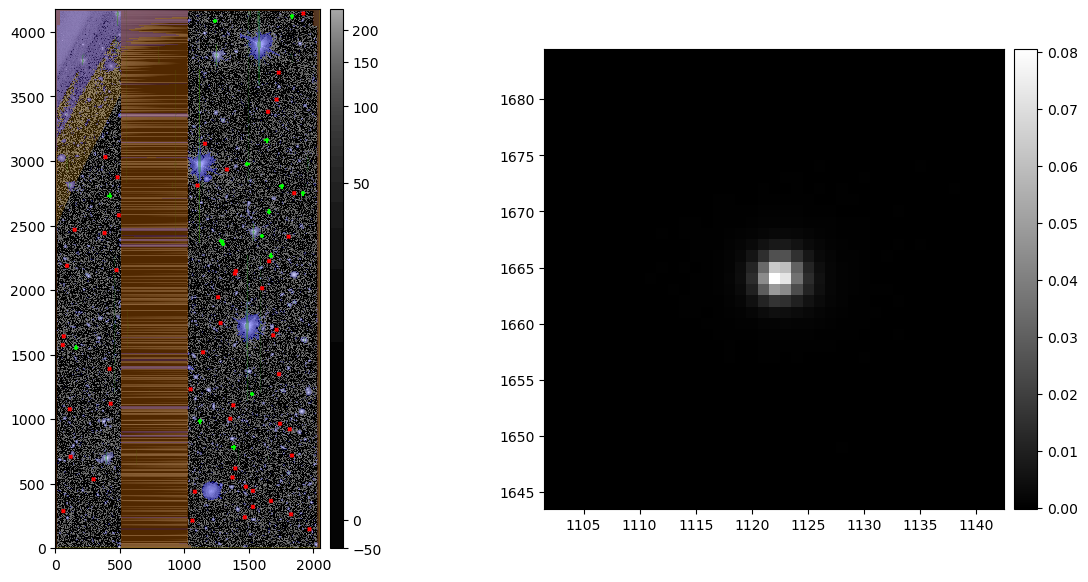

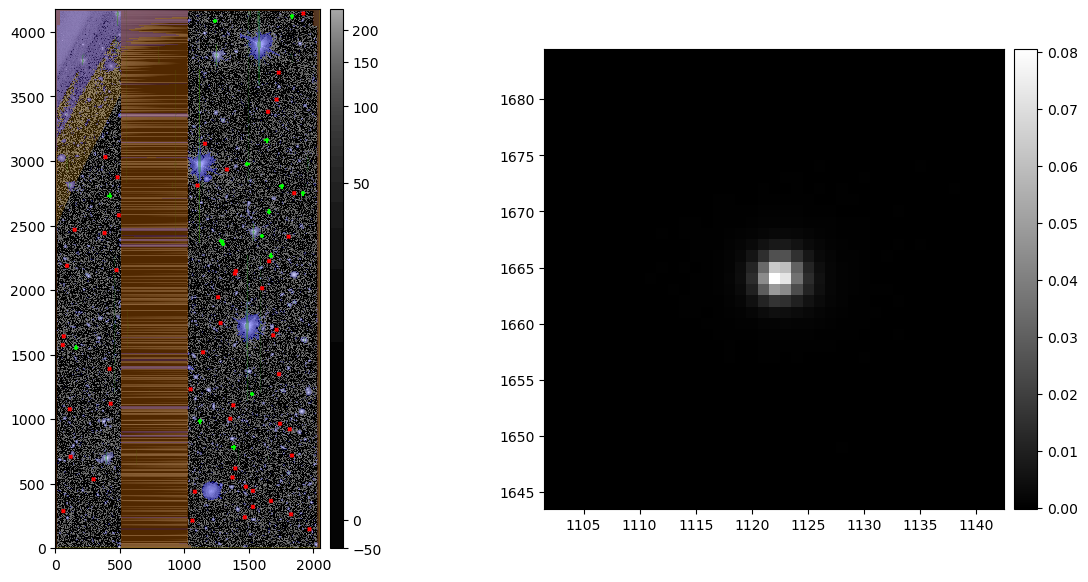

In [38]:
psf_plots(datasetRefs)

As of this moment, an ap_db hasn't succesfully built so I can't use the apdp tools yet to explore the psf yet.

### deepCoadd Selection

This section was added to continue exploring the deepCoadds and different ways of plotting.

In [26]:
afwDisplay.setDefaultBackend('matplotlib') 

dt = registry.getDatasetType('deepCoadd')
print("Name:", dt.name)
print("Dimensions:", dt.dimensions)
print("Storage Class:", dt.storageClass)

Name: deepCoadd
Dimensions: {band, skymap, tract, patch}
Storage Class: ExposureF


In [27]:
datasetType = '*deepCoadd*'
datasetRefs = set(registry.queryDatasets(datasetType, dataId=None))

0 deepCoadd.visitInfo.getId():  30492


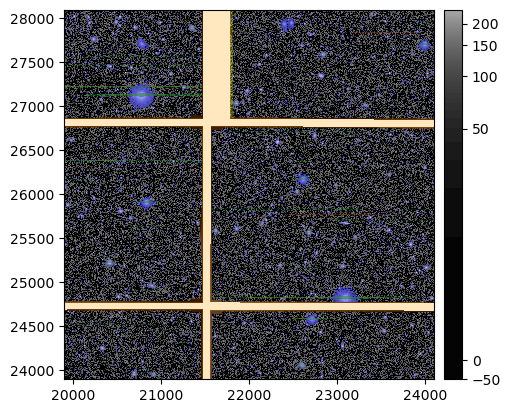

1 deepCoadd.visitInfo.getId():  30486


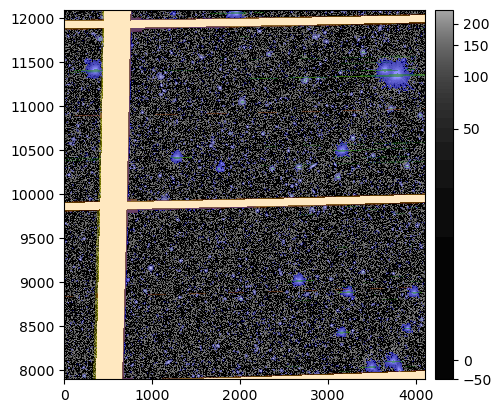

2 deepCoadd.visitInfo.getId():  19660


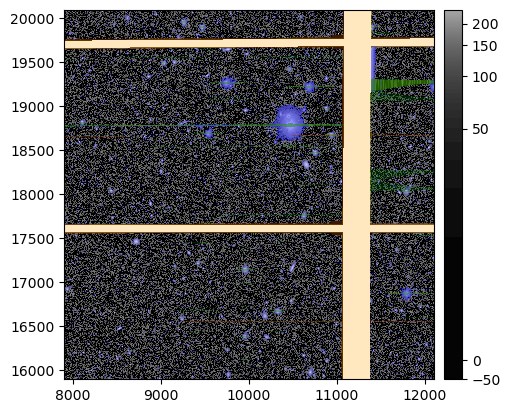

...


In [28]:
for i, ref in enumerate(datasetRefs):
    deepCoadd = butler.getDirect(ref)
        
    try: 
        print(i, 'deepCoadd.visitInfo.getId(): ', deepCoadd.visitInfo.getId())
    
        fig = plt.figure()
        display = afwDisplay.Display(frame=fig)
        display.scale('asinh', -1, 30)
        display.mtv(deepCoadd)
        plt.show()
        if i > 1:
            print('...')
            break

    except AssertionError:
        print(f"{label} image is entirely {np.nanmedian(deepCoadd.image.array)}")

### deepCoadd direct warp variance plot

In [29]:
dataId ={'detector':103,'visit': 30494, 'skymap': 'hsc_rings_v1', 'instrument': 'HSC', 'band': 'i','tract': 9813, 'patch': 31}
datasetRefs = set(registry.queryDatasets(datasetType, dataId=dataId))
hsc_cosmos_i_band_test =  butler.get('deepCoadd_directWarp' , dataId=dataId, collections=[coadd_collection,reprocess_collection])

Median value of the variance pixels: 899.70361328125


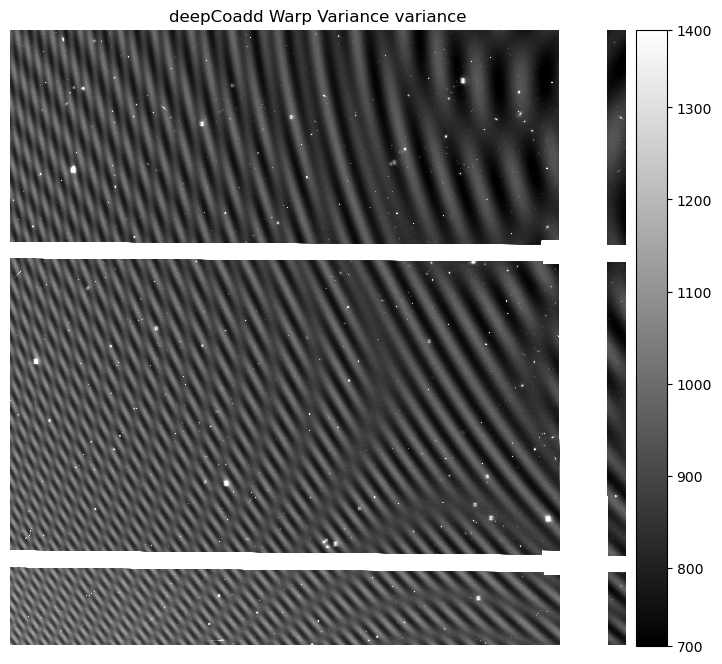

In [30]:
plot_variance(hsc_cosmos_i_band_test, label='deepCoadd Warp Variance')

The following is an example of how to find the tract and patch of a specific detector and visit when the patch and tract are unkown. 

In [31]:
dataId ={'detector':0,'visit': 19682, 'skymap': 'hsc_rings_v1', 'instrument': 'HSC', 'band': 'i'}

9570 72
Median value of the variance pixels: inf


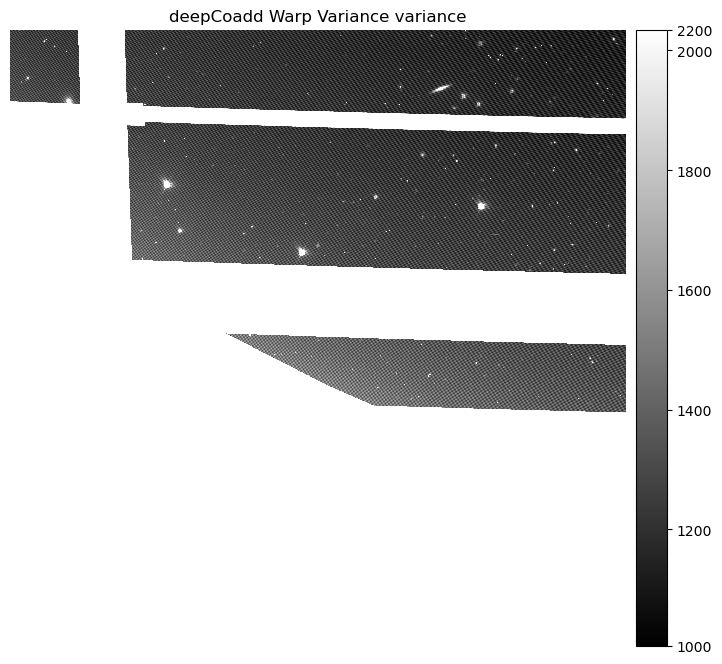

9570 73
Median value of the variance pixels: 1318.749755859375


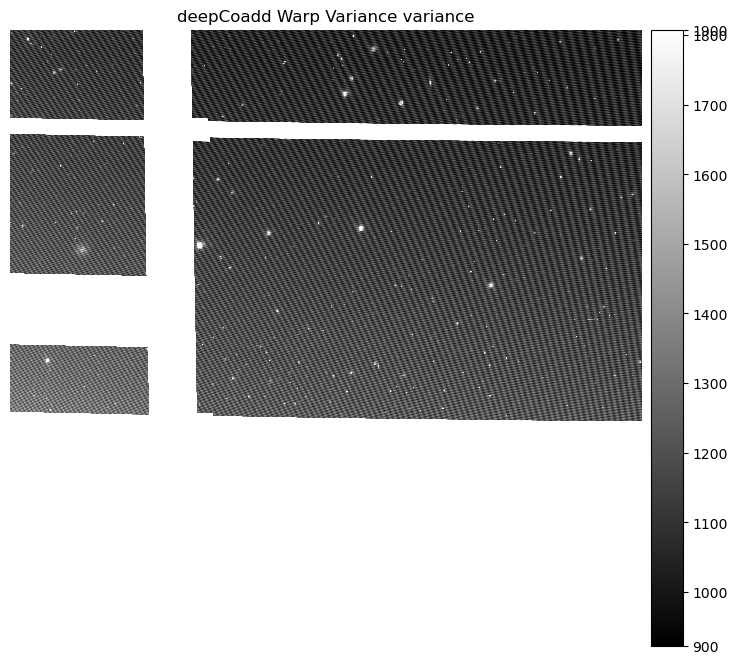

...


In [32]:
i=0
for data_id in butler.registry.queryDataIds(["tract", "visit", "detector", "patch"],
    datasets="visitSummary",
    collections=[coadd_collection,reprocess_collection],
    instrument=instrument,
    visit= 19682,
    detector= 0                                       
):
    
    i=i+1
    print(data_id['tract'], data_id['patch'])
    hsc_cosmos_i_band_test =  butler.get('deepCoadd_directWarp' , dataId=data_id, collections=[coadd_collection,reprocess_collection])
    plot_variance(hsc_cosmos_i_band_test, label='deepCoadd Warp Variance')
    if i > 1:
        print('...')
        break

## Scratch Work Area

In [36]:
psf = calexp.getPsf()

In [37]:
test=calexp.getInfo()

In [38]:
out=test.getId()

In [114]:
src.asAstropy()

<Table length=1619>
        id             coord_ra      ... calib_photometry_reserved
                         rad         ...                          
      int64            float64       ...            bool          
----------------- ------------------ ... -------------------------
13097294463238145 2.6062695704213468 ...                     False
13097294463238146 2.6062249645180042 ...                     False
13097294463238147  2.605994939510711 ...                     False
13097294463238148 2.6058070973563843 ...                     False
13097294463238149  2.605631932978783 ...                     False
13097294463238150 2.6052562925657745 ...                     False
13097294463238151 2.6063953812810476 ...                     False
13097294463238152 2.6052868629237875 ...                     False
13097294463238153 2.6064591705912203 ...                     False
              ...                ... ...                       ...
13097294463239754 2.6064466562573396 ...                     False
13097294463239755  2.606454449285978 ...                     False
13097294463239756 2.6061875421840406 ...                     False
13097294463239757  2.606179525787702 ...                     False
13097294463239758 2.6064396946175665 ...                     False
13097294463239759 2.6064368943609373 ...                     False
13097294463239760 2.6064605734157205 ...                     False
13097294463239761 2.6064658924522304 ...                     False
13097294463239762 2.6064858100877246 ...                     False
13097294463239763  2.606499935360819 ...                     False

In [69]:
src.schema
# This is the full schema of the src table.

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['Flag'](name="calib_detected", doc="Source was detected as an icSource"), Key['Flag'](offset=32, bit=0)),
    (Field['Flag'](name="calib_psf_candidate", doc="Flag set if the source was a candidate for PSF determination, as determined by the star selector."), Key['Flag'](offset=32, bit=1)),
    (Field['Flag'](name="calib_psf_used", doc="Flag set if the source was actually used for PSF determination, as determined by the"), Key['Flag'](offset=32, bit=2)),
    (Field['Flag'](name="calib_psf_reserved", doc="set if source was reserved from PSF determination"), Key['Flag'](offset=32, bit=3)),
    (Fiel

In [139]:
src.getApInstFlux()

array([            nan,             nan,             nan, ...,
         1116.95959473, 788898.75      ,   4457.56054688])

In [124]:
src.getPsfInstFlux()
## Should give me the flux in the flux psf slot

array([  3772.54079306,  10795.44094545,  18784.15636686, ...,
         2817.33629091, 328534.50360469,   1753.40282002])

In [128]:
x = src.schema.getAliasMap()

In [131]:
list(x.items())
### This is a way to get all of the aliases in the schema in a more concise way

[('base_CircularApertureFlux_flag_badCentroid', 'base_SdssCentroid_flag'),
 ('base_GaussianFlux_flag_badCentroid', 'base_SdssCentroid_flag'),
 ('base_GaussianFlux_flag_badShape', 'ext_shapeHSM_HsmSourceMoments_flag'),
 ('base_LocalBackground_flag_badCentroid', 'base_SdssCentroid_flag'),
 ('base_NaiveCentroid_flag_badInitialCentroid', 'base_SdssCentroid_flag'),
 ('base_PsfFlux_flag_badCentroid', 'base_SdssCentroid_flag'),
 ('base_SdssShape_flag_badCentroid', 'base_SdssCentroid_flag'),
 ('base_Variance_flag_badCentroid', 'base_SdssCentroid_flag'),
 ('ext_photometryKron_KronFlux_flag_badInitialCentroid',
  'base_SdssCentroid_flag'),
 ('ext_shapeHSM_HsmPsfMomentsDebiased_flag_badCentroid',
  'base_SdssCentroid_flag'),
 ('ext_shapeHSM_HsmPsfMoments_flag_badCentroid', 'base_SdssCentroid_flag'),
 ('ext_shapeHSM_HsmShapeRegauss_flag_badCentroid', 'base_SdssCentroid_flag'),
 ('ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid',
  'base_SdssCentroid_flag'),
 ('ext_shapeHSM_HsmSourceMoments_fla

In [134]:
x=src.getTable().getPsfFluxSlot()

In [137]:
x.getAlias()

'slot_PsfFlux'

In [141]:
y = src.getTable().getApFluxSlot()

In [143]:
y.getAlias()

'slot_ApFlux'

In [39]:
flux_ratio=src.getApInstFlux()/src.getPsfInstFlux()

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 5.000e+00, 6.000e+00, 1.500e+01, 2.446e+03,
        3.760e+02, 5.500e+01, 1.100e+01, 7.000e+00, 3.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-180.72319453, -175.5967028 , -170.47021106, -165.34371933,
        -160.2172276 , -155.09073586, -149.96424413, -144.837752

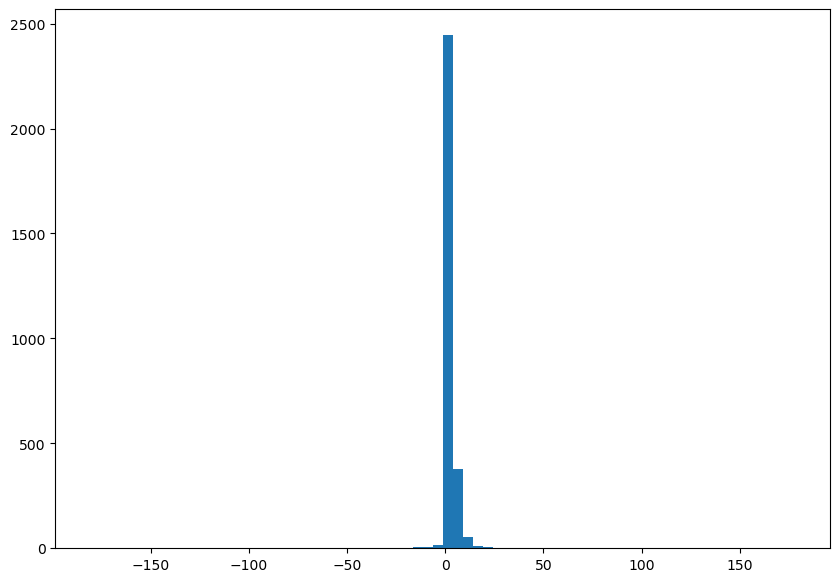

In [40]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(flux_ratio, bins =  70)

(array([   4.,   12.,   55.,  440., 1106.,  609.,  259.,  121.,  158.,
          42.,   28.,   21.]),
 array([-3, -2, -1,  0,  1,  2,  3,  4,  5,  7,  8,  9, 10]),
 <BarContainer object of 12 artists>)

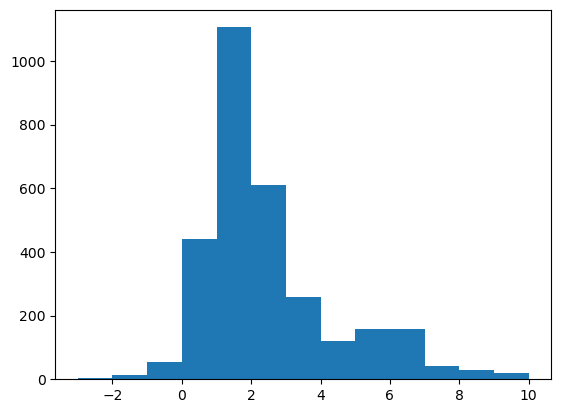

In [49]:
plt.hist(flux_ratio, bins=[-3,-2,-1,0,1,2,3,4,5,7,8,9,10])

In [43]:
flux_ratio

array([       nan,        nan,        nan, ..., 0.97930237, 2.16904773,
       1.27530141])

In [161]:
src.getX()

array([359.        , 418.        , 723.        , ..., 183.98885026,
       170.64613649, 151.5843141 ])

In [162]:
src.getY()

array([   5.        ,    5.        ,    5.        , ..., 2681.8464181 ,
       3024.48496   , 3018.67841699])

In [176]:
list(butler.registry.queryDatasets('source'))

[]

In [15]:
flux_ratio

NameError: name 'flux_ratio' is not defined